we set the steps N equal to: 1000
Part I (a)
the option price based on Monte Carlo is: 8.887182552511948
the option price based on Black-Scholes is: 8.916037278572539

Part I (b) code is hiden by "#"; see report for more details 

part I (c) plots are shown below 

Part II 

The delta_Strategy is: 
{'n_c': -1, 'n_s': 0.579259709439103, 'n_b': -49.00993366533776, 'k': 0}

The deltaGamma_Strategy is: 
{'n_c': -1, 'k': 1.7182637701815389, 'n_s': -0.6989193598958436, 'n_b': 46.86014011011824}



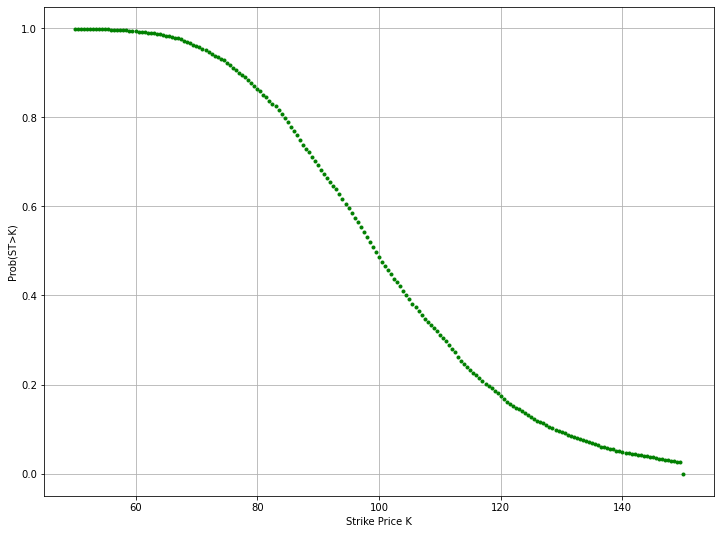

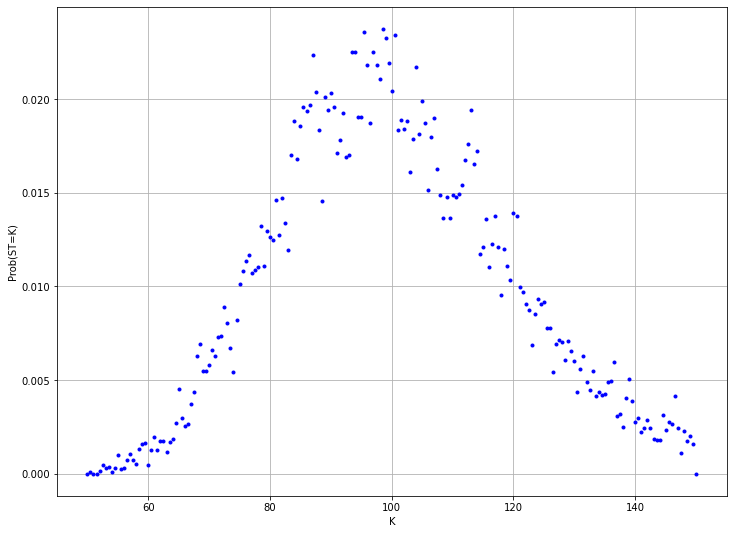

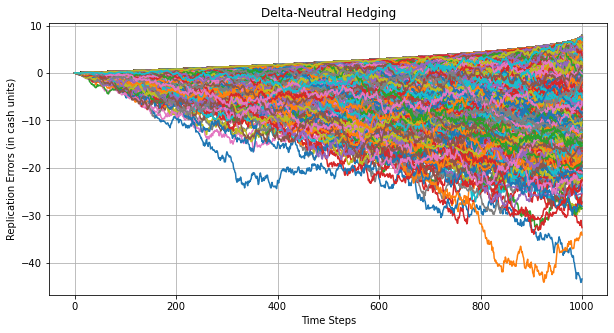

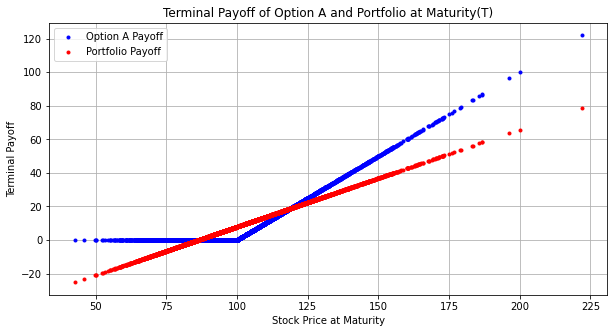

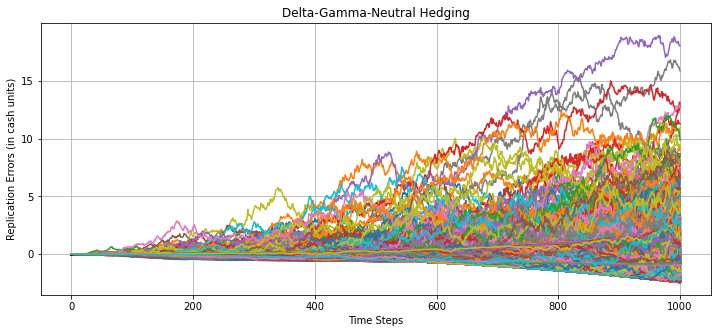

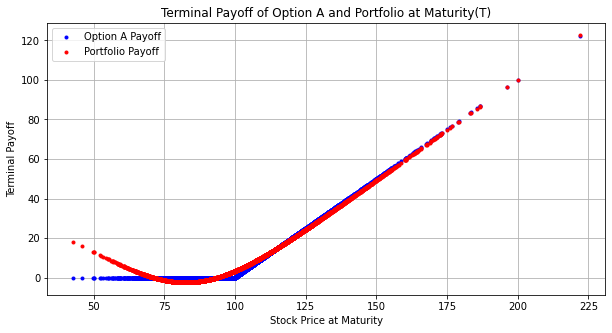

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy

# Functions related with Monte Carlo simulation

def MC_StockPrice(scheme,parameters): 
    
    #setup parameters:
    T = parameters['setup']['period']   # simulated period
    N = parameters['setup']['steps']    # number of steps
    M = parameters['setup']['paths']    # number of simulated paths
    dt = T/N                            # time length of one step
    
    #model parameters:
    S0 = parameters['model']['initial StockPrice'] # stock price at time 0
    Sig = parameters['model']['sigma']             # σ,volatility parameter
    R = parameters['model']['risk-free Rate']      # risk-free rate
   
    
    # create a matrix to store all simulated prices
    logS = np.zeros((N+1,M))
    logS[0,:] = np.log(S0)
    #compute the simulated prices by taking prices of all paths to next step
    
    dt_vector = dt*np.ones(M)
    
    if scheme == 'Euler':
        for i in range(1,N+1):
            Z_vector = np.random.normal(0,1,M)
            logS[i,:] = logS[i-1,:] + (R-0.5*Sig**2)*dt_vector + Sig*np.sqrt(dt)*Z_vector    
    
    elif scheme == 'Milstein':
        for i in range(1,N+1):
            Z_vector = np.random.normal(0,1,M)
            logS[i,:] = logS[i-1,:] + (R-0.5*Sig**2)*dt_vector + Sig*np.sqrt(dt)*Z_vector    
    
    return np.exp(logS) #Simu_SP


def MC_OptionPrice(S_T, parameters):  #S_T carries the simulated stock prices at time T of M paths
    
    #parameters:
    M = parameters['setup']['paths']
    R = parameters['model']['risk-free Rate'] 
    
    K_a = parameters['optionA']['strike Price']
    Type_a = parameters['optionA']['option Type']
    T_a = parameters['optionA']['maturity']
    
    DF = np.exp(-R*T)     #discount factor
    
    #compute the payoffs of option A at time T and option price
    payoffs = np.maximum(0, (S_T- K_a if  Type_a== 1 else (K_a-S_T)))
    option_price = DF*(np.sum(payoffs)/float(M))
    
    return option_price 


#Functions related with Probability distribution

def Pro_Of_K_Higher(Ks,MC_optionprice_Ks, Factor): 
# MC_optionprice_Ks carries the prices of option based on strike prices in Ks
# use Factor get corresponding future value
    
    numOfK = len(Ks)             #number of K
    PartialD = np.zeros(numOfK)
    for i in range(0,numOfK-1):  # 0 <= i <= numOfK-2
        
        dK = Ks[i+1] - Ks[i]  # k in ascending order
        price_k = MC_optionprice_Ks[i]          # C(K)
        price_k_plus1 = MC_optionprice_Ks[i+1]  # C(K+dK)
        
        PartialD[i] = (price_k_plus1 - price_k)/dK  
        
        probs_cum = -PartialD * Factor
    
    return probs_cum  

def Pro_Of_K_Equal(Ks,MC_optionprice_Ks,Factor): 
    
    numOfK = len(Ks)
    SecPartialD = np.zeros(numOfK)
    
    for i in range(1,numOfK-1):  # 1 <= i < numOfK-2
        dK = Ks[i] - Ks[i-1] 
        price_k_plus1 = MC_optionprice_Ks[i+1]  #C(K+dK)
        price_k = MC_optionprice_Ks[i]          #C(K)
        price_k_minus1 = MC_optionprice_Ks[i-1] #C(K-dK)
        
        SecPartialD[i] = (price_k_plus1 - 2*price_k + price_k_minus1)/(dK**2)
        
        probs_den = SecPartialD * Factor
    
    return probs_den  


# Function related with Black-Scholes model

def BS_OptionPrice(parameters,option_name = 'A',St = 100,t = 0):
    # default St is S0 = 100. It can also compute the option price of B in later use.
    # Moreover, St could be a verctor, carrying all posiible stock prices at time t.
    # This is designed to calculating multiple option prices for later use.
    Sig = parameters['model']['sigma']
    R = parameters['model']['risk-free Rate']
    
    K = parameters['optionA']['strike Price'] if option_name == 'A' else parameters['optionB']['strike Price']
    
    Type = parameters['optionA']['option Type'] if option_name == 'A' else parameters['optionB']['option Type']
    
    T = parameters['optionA']['maturity'] if option_name == 'A' else parameters['optionB']['maturity']
    
    DF = np.exp(-R*(T-t))
    d1 = (np.log(St/K)+(R+0.5*Sig**2)*(T-t))/(Sig*np.sqrt(T-t))
    d2 = d1 - Sig*np.sqrt(T-t)
    
    option_price = (St * norm.cdf(d1*Type) - K * DF * norm.cdf(d2*Type))*Type
    
    return option_price



def BS_Delta(parameters,option_name):
    S0 = parameters['model']['initial StockPrice']
    Sig = parameters['model']['sigma']
    R = parameters['model']['risk-free Rate']
    
    Type = parameters['optionA']['option Type'] if option_name == 'A' else parameters['optionB']['option Type'] 
    K = parameters['optionA']['strike Price'] if option_name == 'A' else parameters['optionB']['strike Price']
    T = parameters['optionA']['maturity'] if option_name == 'A' else parameters['optionB']['maturity']
    
    d1 = (np.log(S0/K)+(R+0.5*Sig**2)*T)/(Sig*np.sqrt(T))
    
    bs_delta = norm.cdf(d1) if Type == 1 else norm.cdf(d1) - 1 
    
    return bs_delta


def BS_Gamma(parameters,option_name):
    S0 = parameters['model']['initial StockPrice']
    Sig = parameters['model']['sigma']
    R = parameters['model']['risk-free Rate']
    
    
    K = parameters['optionA']['strike Price'] if option_name == 'A' else parameters['optionB']['strike Price']
    T = parameters['optionA']['maturity'] if option_name == 'A' else parameters['optionB']['maturity']
    
    d1 = (np.log(S0/K)+(R+0.5*Sig**2)*T)/(Sig*np.sqrt(T))
    
    bs_gamma = norm.pdf(d1)/(S0*Sig*np.sqrt(T))
    
    return bs_gamma


#Functions related with Hedging Strategy
def Delta_Gamma_NeutralHedging(parameters,hedging_type):
    S0 = parameters['model']['initial StockPrice']
    deltaA = BS_Delta(parameters,'A')
    gammaA = BS_Gamma(parameters,'A')
    deltaB = BS_Delta(parameters,'B')
    gammaB = BS_Gamma(parameters,'B')
    priceOf_A = BS_OptionPrice(parameters,'A')
    priceOf_B = BS_OptionPrice(parameters,'B')
    strategy = {} #create an empty dictionary
    if hedging_type == 'delta':
        strategy['n_c'] = -1
        strategy['n_s'] = -strategy['n_c']*deltaA
        strategy['n_b'] = -strategy['n_c'] * priceOf_A  - strategy['n_s'] * S0
        strategy[ 'k' ] = 0
    
    elif hedging_type == 'delta and gamma': 
        strategy['n_c'] = -1 
        strategy[ 'k' ] = - (strategy['n_c'] * gammaA / gammaB)
        strategy['n_s'] = - strategy['n_c'] * deltaA - strategy['k']* deltaB
        strategy['n_b'] = - (strategy['n_c'] * priceOf_A + strategy['n_s']* S0 + strategy['k'] * priceOf_B)
    
    return strategy


def Replication_error(Simu_SP,strategy,parameters):
    T = parameters['setup']['period']  #time of maturity
    N = parameters['setup']['steps']  # number of steps
    M = parameters['setup']['paths']  # number of simulated paths
    dt = T/N
    S0 = parameters['model']['initial StockPrice']
    Sig = parameters['model']['sigma']
    R = parameters['model']['risk-free Rate'] 
    n_c = strategy['n_c']
    n_s = strategy['n_s']
    n_b = strategy['n_b'] 
    k   = strategy[ 'k' ]
    
    K_a = parameters['optionA']['strike Price'] 
    T_a = parameters['optionA']['maturity']
    Type_a = parameters['optionA']['option Type']
    
    K_b = parameters['optionB']['strike Price']  
    T_b = parameters['optionB']['maturity']   
    Type_b = parameters['optionB']['option Type']

    # replication errors  
    PV = np.zeros((N+1,M),float) #portfolio value 
   
    # t at 0
    PV[0,:] = 0
    B0 = 1  #initial bond price
   
    for n in range(1,N+1):
        S_t = Simu_SP[n,:]
        t = n*dt
        
        if t < T_a:
            optionpriceA_t = BS_OptionPrice(parameters,'A',S_t,t)
        elif t==T_a:
            optionpriceA_t = np.maximum(0,(S_t - K_a) if Type_a == 1 else (K_a - S_t))    
        
        if k != 0:  # 'k is not 0' means delta-gamma-neutral hedging
            if t < T_b:
                optionpriceB_t = BS_OptionPrice(parameters,'B',S_t,t)
            elif t==T_b:
                optionpriceB_t = np.maximum(0,(S_t - K_b) if Type_b == 1 else (K_b - S_t))  
            
        else: #k=0  delta-neutral hedging
            optionpriceB_t = 0
                                                                                         
                                                                                         
        PV[n,:] = n_c*optionpriceA_t+ n_s*S_t + n_b*B0*(np.exp(R*t)) + k*optionpriceB_t
                
    return  PV
     
    
def TerminalPayoffOfOption(S_T,strategy,parameters):
    K_a= parameters['optionA']['strike Price']
    Type_a = parameters['optionA']['option Type']
    option_payoff = np.maximum(0, (S_T- K_a) if Type_a == 1 else (K_a-S_T)) 
        
    return option_payoff
# The terminal payoff the rest of the portfolio equals to: 
# 'replication error at time t' + 'terminal payoff of optionA'
                                                                  
    
if __name__=="__main__": # main function
        
    T = 1    
    N = 1000
    print('we set the steps N equal to: '+ str(N))
    M = 5000
    
    S0 = 100     
    Sig = 0.20
    R = 0.02
    
    K_a = 100
    Type_a = 1 
    T_a = T
    
    K_b = 90
    Type_b = 1
    T_b = 2
    
    
    parameters = {'setup':{'period':T, 'steps':N, 'paths':M},
                  'model':{'initial StockPrice':S0, 'sigma':Sig, 'risk-free Rate':R},
                  'optionA':{'strike Price':K_a, 'option Type': Type_a, 'maturity':T_a},
                  'optionB':{'strike Price':K_b, 'option Type': Type_b, 'maturity':T_b}
                  }
    
    
    
    
    # Part I  (a)
    print('Part I (a)')
    Simu_SP = MC_StockPrice('Euler',parameters)
    S_T = Simu_SP[-1,:]
    MC_option_price = MC_OptionPrice(S_T,parameters)
    BS_option_price = BS_OptionPrice(parameters)
    print('the option price based on Monte Carlo is: '+ str(MC_option_price))
    print('the option price based on Black-Scholes is: '+ str(BS_option_price)+ '\n')
    
          
    #Part I (b)
    print('Part I (b) code is hiden by "#"; see report for more details \n')      
#     #1)
#     num_M  = np.linspace(1000,10000,73)
#     row = -1
#     num_Test  = 100
#     parameters_new = deepcopy(parameters)
#     test_record = np.zeros((len(num_M), num_Test))
#     test_mean = np.zeros((len(num_M),1))
#     for m in num_M:
#         parameters_new['setup']['paths'] = int(m)
#         row = row +1 
#         for j in range(num_Test):
#             Simu_SP_new = MC_StockPrice('Euler',parameters_new)
#             S_T_new = Simu_SP_new[-1,:]
#             test_record[row][j] = MC_OptionPrice(S_T_new,parameters_new)
#         test_mean[row] = np.mean(test_record[row,:])
    
#     fig = plt.figure(figsize=(10,5))
    
#     plt.plot(test_record,'b.')
#     plt.hlines(BS_option_price,0,73,color = 'green')
#     plt.plot(test_mean,'r')
#     plt.grid(True)
#     plt.xlabel('M')
#     plt.ylabel('MC_OptionPrice')
#     plt.title('M spot plot') 

#     #2)
#     num_N  = np.linspace(500,7000, 53)
#     row = -1
#     num_Test  = 100
#     parameters_new = deepcopy(parameters)
#     test_record = np.zeros((len(num_N), num_Test))
#     test_mean = np.zeros((len(num_N),1))
#     for n in num_N:
#         parameters_new['setup']['steps'] = int(n)
#         row = row +1 
#         for j in range(num_Test):
#             Simu_SP_new = MC_StockPrice('Euler',parameters_new)
#             S_T_new = Simu_SP_new[-1,:]
#             test_record[row][j] = MC_OptionPrice(S_T_new,parameters_new)
#         test_mean[row] = np.mean(test_record[row,:])
    
    
#     fig = plt.figure(figsize=(10,5))
    
#     plt.plot(test_record,'b.')
#     plt.hlines(BS_option_price,0,53,color = 'green')
#     plt.plot(test_mean,'r')
#     plt.grid(True)
#     plt.xlabel('N')
#     plt.ylabel('MC_OptionPrice')
#     plt.title('N spot plot') 


   
    # Part I (c)
    print('part I (c) plots are shown below \n')
    Ks = np.arange(50,150.5,0.5,float)
    numOfK = len(Ks)
    MC_optionprice_Ks = np.zeros(numOfK)
    parameters_test = deepcopy(parameters)
    for i in range(numOfK):
        parameters_test['optionA']['strike Price'] = Ks[i]
        MC_optionprice_Ks[i] = MC_OptionPrice(S_T,parameters_test)     
  
    Factor = np.exp(R*T_a)
    
    ProHigherThanK = Pro_Of_K_Higher(Ks,MC_optionprice_Ks,Factor)

    ProEqualToK = Pro_Of_K_Equal(Ks,MC_optionprice_Ks,Factor)

    #plot probabilities
    plt.figure(figsize=(12,9))
    plt.plot(Ks, ProHigherThanK, 'g.')
    plt.grid(True)
    plt.xlabel('Strike Price K')
    plt.ylabel('Prob(ST>K)')
    
    plt.figure(figsize=(12,9))
    plt.plot(Ks, ProEqualToK, 'b.')
    plt.grid(True)
    plt.xlabel('K')
    plt.ylabel('Prob(ST=K)')
    
    
    
    
    #Part II
    print('Part II \n')
    
    #Part II (d) delta-neutral hedging
    #1)
    delta_Strategy = Delta_Gamma_NeutralHedging(parameters,'delta',)
    print('The delta_Strategy is: ')
    print(str(delta_Strategy) +'\n')
    
    PV_delta = Replication_error(Simu_SP,delta_Strategy,parameters)
    
    fig = plt.figure(figsize=(10,5))
    plt.plot(PV_delta)
    plt.grid(True)
    plt.xlabel('Time Steps')
    plt.ylabel('Replication Errors (in cash units)')
    plt.title('Delta-Neutral Hedging')
    
    # 2)
    optionA_payoff = TerminalPayoffOfOption(S_T,delta_Strategy,parameters)
    portfolio_payoff = (PV_delta[-1,:] + optionA_payoff)
    
    fig = plt.figure(figsize=(10,5))
    payoffOptionA = np.transpose([Simu_SP[-1,:],optionA_payoff])
    new_payoffOptionA = payoffOptionA[np.lexsort(payoffOptionA[:,::-1].T)]
    plt.plot(new_payoffOptionA[:,0],new_payoffOptionA[:,1],"b.",label='Option A Payoff')
    
    payoffPortfolio = np.transpose([Simu_SP[-1,:],portfolio_payoff])
    new_payoffPortfolio = payoffPortfolio[np.lexsort(payoffPortfolio[:,::-1].T)]
    plt.plot(new_payoffPortfolio[:,0],new_payoffPortfolio[:,1],"r.",label='Portfolio Payoff')
    
    plt.legend(loc=0) 
    plt.grid(True)
    plt.xlabel('Stock Price at Maturity')
    plt.ylabel('Terminal Payoff')
    plt.title('Terminal Payoff of Option A and Portfolio at Maturity(T)')
    
    
    # Part II (e) delta-gamma-neutral hedging
    
    # 1)
    deltaGamma_Strategy = Delta_Gamma_NeutralHedging(parameters,'delta and gamma')
    print('The deltaGamma_Strategy is: ')
    print(str(deltaGamma_Strategy) +'\n')
    
    PV_deltaGamma = Replication_error(Simu_SP,deltaGamma_Strategy,parameters)
    
    fig = plt.figure(figsize=(12,5))
    plt.plot(PV_deltaGamma)
    plt.grid(True)
    plt.xlabel('Time Steps')
    plt.ylabel('Replication Errors (in cash units)')
    plt.title('Delta-Gamma-Neutral Hedging')
    
    # 2)
    portfolio_payoff_DGN = (PV_deltaGamma[-1,:] + optionA_payoff)
    
    fig = plt.figure(figsize=(10,5))
    payoffOptionA = np.transpose([Simu_SP[-1,:],optionA_payoff])
    new_payoffOptionA = payoffOptionA[np.lexsort(payoffOptionA[:,::-1].T)]
    plt.plot(new_payoffOptionA[:,0],new_payoffOptionA[:,1],"b.",label='Option A Payoff')
    
    payoffPortfolio = np.transpose([Simu_SP[-1,:],portfolio_payoff_DGN])
    new_payoffPortfolio = payoffPortfolio[np.lexsort(payoffPortfolio[:,::-1].T)]
    plt.plot(new_payoffPortfolio[:,0],new_payoffPortfolio[:,1],"r.",label='Portfolio Payoff')
    plt.legend(loc=0) 
    plt.grid(True)
    plt.xlabel('Stock Price at Maturity')
    plt.ylabel('Terminal Payoff')
    plt.title('Terminal Payoff of Option A and Portfolio at Maturity(T)')


    
